In [368]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import ridder

## Internal wave eigenproblem for $U(z)=0$

$$W_n'' + k_n^2 \frac{N^2(z)-\omega^2}{\omega^2-f^2}W_n = 0$$

$$\rightarrow \frac{d\mathbf{y}}{dz} = \begin{bmatrix} 0 & -k^2 \frac{N^2(z)-\omega^2}{\omega^2-f^2} \\ 1 & 0 \end{bmatrix} \mathbf{y} \qquad\text{where}\qquad \mathbf{y} = \begin{bmatrix} \frac{dW}{dz} \\ W \end{bmatrix}$$

In [369]:
def dydz(y,zi,k,w,z,N,f):
    N_ = np.interp(zi,z,N)
    A = np.array([[0,-k**2 * (N_**2-w**2)/(w**2-f**2)],[1,0]])
    return A @ y

def integrate(k,y0,w,z,N,f):
    # calculates y = [dW/dz,W]
    y = odeint(dydz,y0,z,args=((k,w,z,N,f)))
    return y

def evaluate(k,w,z,N,f):
    # returns only the value W(z=H)
    y0 = [1,0]
    y = integrate(k,y0,w,z,N,f)[-1,:]
    return y[1]

def dispersion(cmin,cmax,nc,w,z,N,f,all_modes=False,num_modes=10):
    y0 = np.array([1,0])
    cs = np.logspace(np.log10(cmin),np.log10(cmax),nc)
    ys = np.zeros(nc)
    for ic,c in enumerate(cs):
        k_ = w/c
        ys[ic] = evaluate(k_,w,z,N,f)
    diff = np.diff(np.sign(ys))
    brac = np.argwhere(abs(diff)>1).flatten()
    nb = np.minimum(len(brac),num_modes)
    nnb = len(brac)
    if all_modes:
        cp = []
        for ib in range(nb):
            a = w/cs[brac[nnb-ib-1]+1]
            b = w/cs[brac[nnb-ib-1]]
            k = ridder(evaluate,a,b,(w,z,N,f))
            cp.append(w/k)
    elif len(brac)>0:
        a = w/cs[brac[-1]+1]
        b = w/cs[brac[-1]]
        k = ridder(evaluate,a,b,(w,z,N,f))
        cp = w/k
    else:
        cp = np.nan
    return cp


### Case of uniform stratification ($N=const$):

$$k_n = \pm \frac{n\pi}{H} \left(\frac{\omega^2-f^2}{N^2-\omega^2}\right)^{1/2}$$
$$W_n = \sin{\left(\frac{n\pi z}{H}\right)}$$

In [370]:
## Parameters
nz = 20                      # num points to evaluate eigenfunction
H = 100                      # water depth (m)
z = np.linspace(0,H,nz)      # depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
N = 1e-2*np.ones(nz)         # buoyancy frequency (rad/s)
nw = 20
ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest

## Compute dispersion
cmin = 0.01 # m/s
cmax = 10
nc = 100
all_modes = True

nn = 3 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes,num_modes=3)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

In [371]:
## Analytical solution
cn = np.zeros((nw,nn))
Wn = np.zeros((nw,nz,nn))
for n in range(nn):
    cn[:,n] = ws/((np.pi*(n+1)/H)*np.sqrt((ws**2-f**2)/(N[0]**2-ws**2)))
    Wn[:,:,n] = np.sin((n+1)*np.pi*z/H)

Text(0, 0.5, 'Depth (m)')

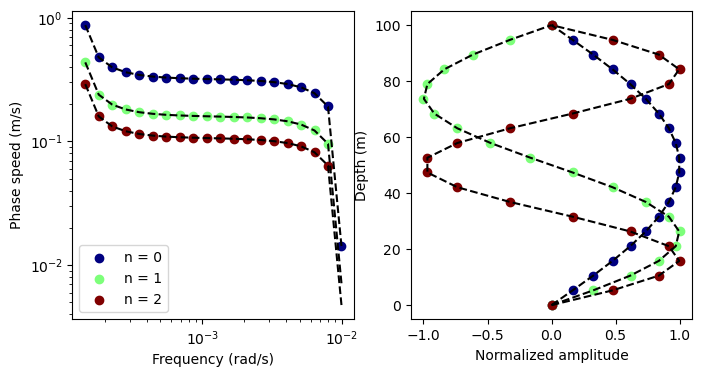

In [372]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,2,figsize=(8,4))
for n in range(nn):
    ax[0].plot(ws,cn[:,n],'k--')
    ax[0].scatter(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='lower left')

for n in range(nn):
    ax[1].plot(Wn[0,:,n],z,'k--')
    ax[1].scatter(W[0,:,n]/max(abs(W[0,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')

### Layered stratification

In [373]:
## Parameters
nz = 50                      # num points to evaluate eigenfunction
H = 100                      # water depth (m)
z = np.linspace(0,H,nz)      # depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
N = np.ones(nz)*1e-2              # buoyancy frequency (rad/s)
H0 = H//2
N[np.logical_and(z>=H0//4,z<=H0//2)] = 2e-2
N[np.logical_and(z>=H0//2,z<=3*H0//4)] = 1e-2
N[z>=3*H//4] = 2e-2
nw = 10
ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest

## Compute dispersion
cmin = 0.1 # m/s
cmax = 5
nc = 80
all_modes = True

nn = 3 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

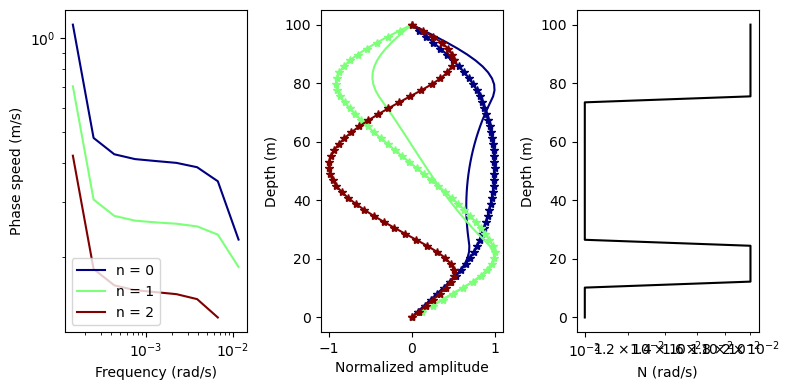

In [374]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,3,figsize=(8,4))
for n in range(nn):
    #ax[0].plot(ws,cn[:,n],'k--')
    ax[0].plot(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='lower left')

for n in range(nn):
    #ax[1].plot(Wn[0,:,n],z,'k--')
    ax[1].plot(W[0,:,n]/max(abs(W[0,:,n])),z,color=colors[n],marker='*')
    ax[1].plot(W[-2,:,n]/max(abs(W[-2,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')

ax[2].plot(N,z,'k')
ax[2].set_xlabel('N (rad/s)')
ax[2].set_ylabel('Depth (m)')
ax[2].set_xscale('log')

plt.tight_layout()

### Greenfjord N-profile

In [383]:
tmp = np.genfromtxt('Depth_Temp_N.csv',delimiter=',',skip_header=2)
z = tmp[:,0]
N = np.convolve(tmp[:,1],np.ones(10)/10,mode='same')
T = np.convolve(tmp[:,2],np.ones(10)/10,mode='same')

In [378]:
## Parameters
nz = len(z)                  # num points to evaluate eigenfunction
H = max(z)                   # water depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
#nw = 15
#ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest
ws = np.array([2*np.pi/(12*60*60),2*np.pi/(15*60)])
nw = len(ws)

## Compute dispersion
cmin = 0.05 # m/s
cmax = 2
nc = 100
all_modes = True

nn = 10 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    print(i+1,nw)
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes,num_modes=nn)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

1 2
2 2


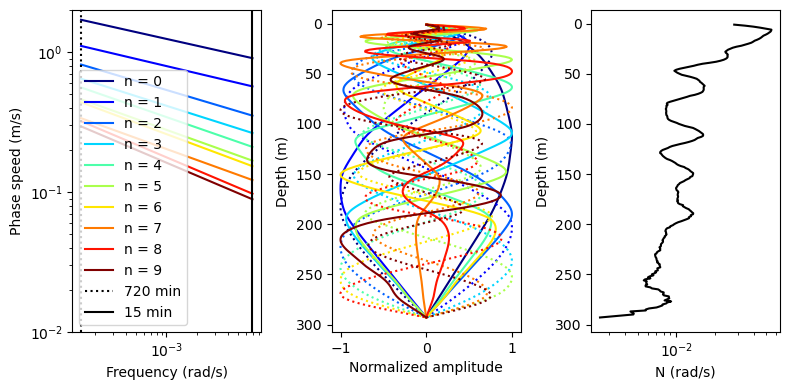

In [379]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,3,figsize=(8,4))
for n in range(nn):
    ax[0].plot(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].axvline(ws[0],c='k',linestyle=':',label='%d min'%(2*np.pi/ws[0]/60))
ax[0].axvline(ws[1],c='k',label='%d min'%(2*np.pi/ws[1]/60))
ax[0].legend(loc='lower left')

for n in range(nn):
    ax[1].plot(W[0,:,n]/max(abs(W[0,:,n])),z,color=colors[n],linestyle=':')
    ax[1].plot(W[1,:,n]/max(abs(W[1,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')



ax[2].plot(N,z,'k')
ax[2].set_xlabel('N (rad/s)')
ax[2].set_ylabel('Depth (m)')
ax[2].set_xscale('log')

ax[0].set_ylim([0.01,2])
ax[1].invert_yaxis()
ax[2].invert_yaxis()

plt.tight_layout()

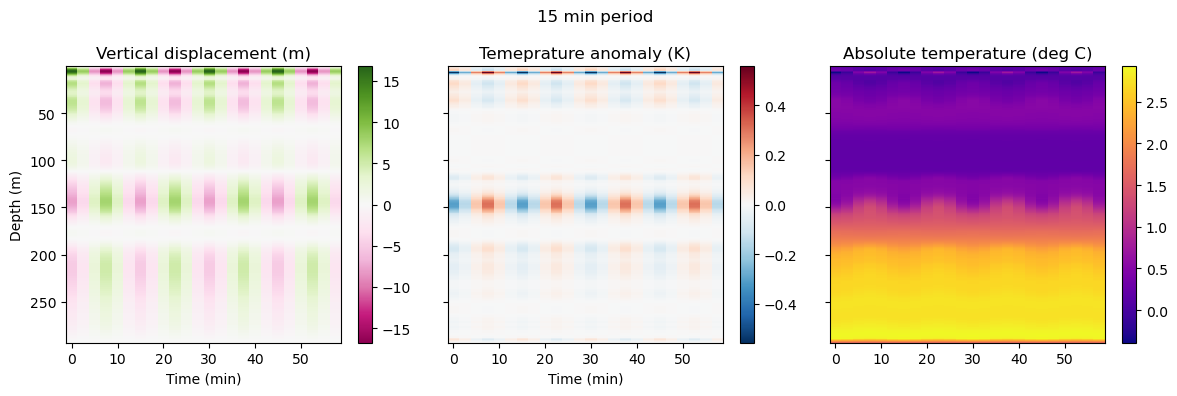

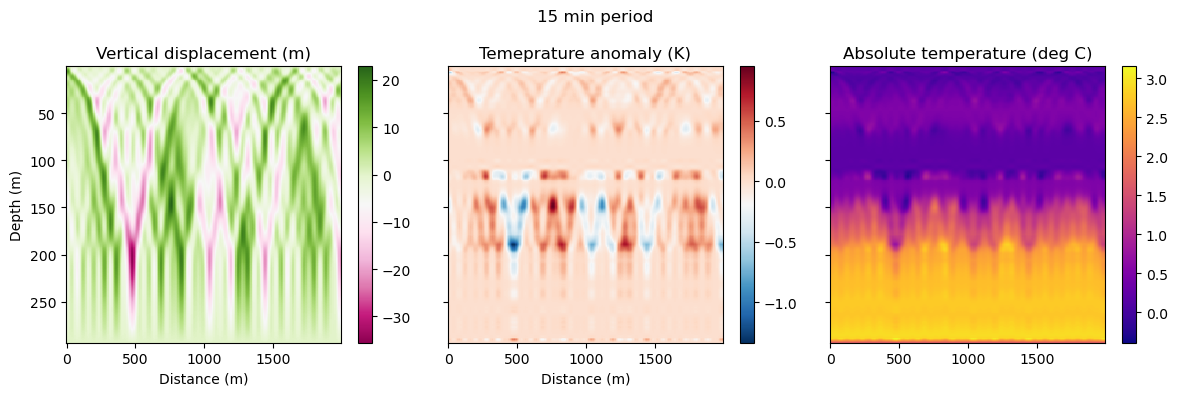

In [403]:
## Create synthetic data

# depth slice across time
dt = 150
t = np.arange(0,60*60,dt)
nt = len(t)
tt,zz = np.meshgrid(t,z)

iw = 1 # which frequency
w = ws[iw]
A = np.ones(nn)*5 # all modes get equal amplitude??
D = np.zeros(tt.shape)
dTdz = np.tile(np.gradient(T),(nt,1)).T
for n in range(nn):
    D += A[n] * np.cos(w*tt) * np.tile(W[iw,:,n]/max(W[iw,:,n]),(nt,1)).T 
DT = D * dTdz
DT_abs = DT + np.tile(T,(nt,1)).T

fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))
im0 = ax[0].pcolormesh(tt/60,zz,D,cmap='PiYG')
im1 = ax[1].pcolormesh(tt/60,zz,DT,cmap='RdBu_r')
im2 = ax[2].pcolormesh(tt/60,zz,DT_abs,cmap='plasma')
ax[0].set_xlabel('Time (min)')
ax[1].set_xlabel('Time (min)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Vertical displacement (m)')
ax[1].set_title('Temeprature anomaly (K)')
ax[2].set_title('Absolute temperature (deg C)')
plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
ax[1].invert_yaxis()
fig.suptitle('%d min period' % (2*np.pi/w/60))
fig.tight_layout()


# depth slice across distance
dx = 10
x = np.arange(0,2e3,dx)
nx = len(x)
xx,zz = np.meshgrid(x,z)

iw = 1 # which frequency
w = ws[iw]
A = np.ones(nn)*5 # all modes get equal amplitude??
D = np.zeros(xx.shape)
dTdz = np.tile(np.gradient(T),(nx,1)).T
for n in range(nn):
    D += A[n] * np.cos(w*xx/c[iw,n]) * np.tile(W[iw,:,n]/max(W[iw,:,n]),(nx,1)).T 
DT = D * dTdz
DT_abs = DT + np.tile(T,(nx,1)).T


fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))
im0 = ax[0].pcolormesh(xx,zz,D,cmap='PiYG')
im1 = ax[1].pcolormesh(xx,zz,DT,cmap='RdBu_r')
im2 = ax[2].pcolormesh(xx,zz,DT_abs,cmap='plasma')
ax[0].set_xlabel('Distance (m)')
ax[1].set_xlabel('Distance (m)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Vertical displacement (m)')
ax[1].set_title('Temeprature anomaly (K)')
ax[2].set_title('Absolute temperature (deg C)')
plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
ax[1].invert_yaxis()
fig.suptitle('%d min period' % (2*np.pi/w/60))
fig.tight_layout()

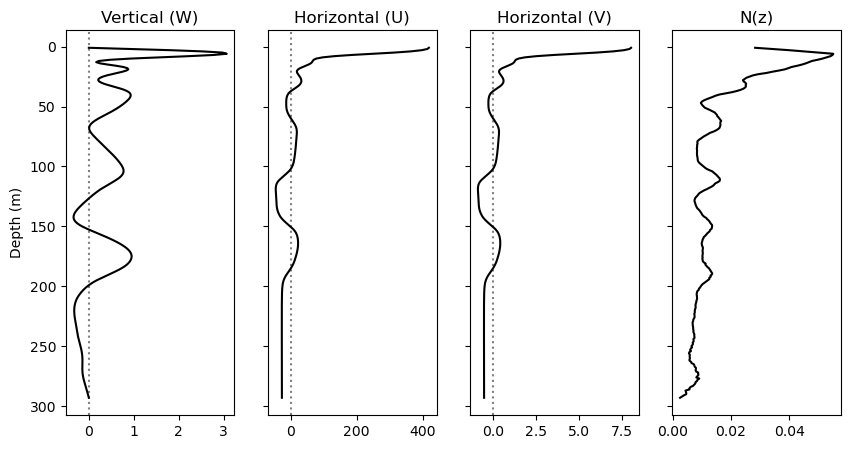

In [381]:
## Plot the modes

iw = 1

W_ = np.zeros(len(W[iw,:,n]))
U_ = W_.copy()
V_ = W_.copy()

for n in range(nn):
    W_ += W[iw,:,n]/max(abs(W[iw,:,n]))
    wn = ws[iw]
    kn = wn/c[iw,n]
    U_ += (1./kn)*np.gradient(W[iw,:,n],z)
    V_ += (f/wn/kn)*np.gradient(W[iw,:,n],z)

    
fig,ax = plt.subplots(1,4,sharey=True,figsize=(10,5))
ax[0].axvline(0,c='gray',linestyle=':')
ax[0].plot(W_,z,'k')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Vertical (W)')
ax[1].axvline(0,c='gray',linestyle=':')
ax[1].plot(U_,z,'k')
ax[1].set_title('Horizontal (U)')
ax[2].axvline(0,c='gray',linestyle=':')
ax[2].plot(V_,z,'k')
ax[2].set_title('Horizontal (V)')
ax[3].plot(N,z,'k')
ax[3].set_title('N(z)')
ax[0].invert_yaxis()

Text(0.5, 1.0, 'Horizontal')

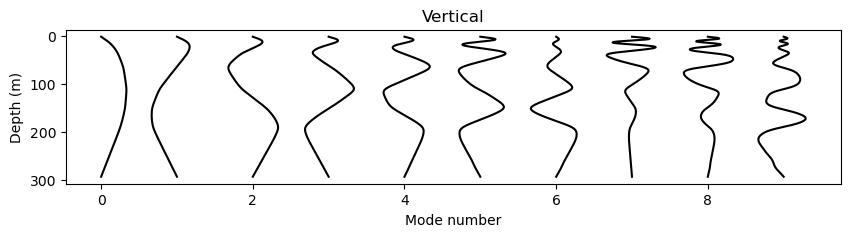

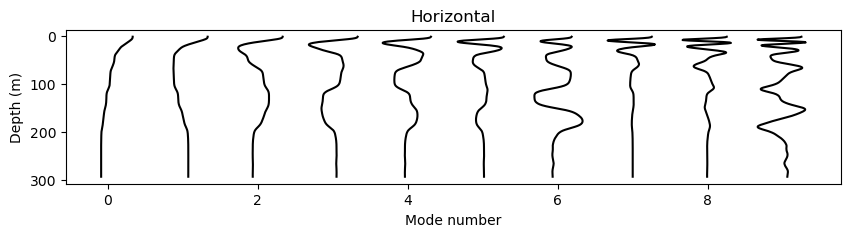

In [382]:
plt.figure(figsize=(10,2))
for n in range(nn):
    plt.plot(W[iw,:,n]/max(abs(W[iw,:,n]))/3+n,z,'k')#color=colors[n])
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Mode number')
plt.title('Vertical')

plt.figure(figsize=(10,2))
for n in range(nn):
    wn = ws[iw]
    kn = wn/c[iw,n]
    Ui = (1./kn)*np.gradient(W[iw,:,n],z)
    Ui /= max(abs(Ui))
    plt.plot(Ui/3+n,z,'k')#color=colors[n])
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Mode number')
plt.title('Horizontal')